In [4]:
"""
In this code, I demonstrate the implementation of the Chan-Vese segmentation method for image processing. 
I use a level-set approach to evolve a contour, enabling the segmentation of objects in images. 
The code is structured with the main function chanvese, which takes an input image, initial mask, 
    maximum number of iterations, regularization parameter alpha, threshold, color for display, 
    and an optional display flag.

The core of the Chan-Vese algorithm is executed in the main loop, 
    which I iterate until reaching the maximum iterations or convergence. 
I evolve the contour based on image information and curvature penalty. 
Signed distance functions are used to maintain smoothness, and I check for convergence periodically.
"""

import numpy as np
import scipy.ndimage as nd
import matplotlib.pyplot as plt

eps = np.finfo(float).eps

# takes input image, initial mask, maximum number of iterations, regularization parameter alpha, 
# threshold, color for display, and an optional display flag
def chanvese(I, init_mask, max_its, alpha, thresh=0, color='r', display=False, stepsize=20):
    I = I.astype(np.float64)

    # Converts a mask to a signed distance map (SDF)
    phi = nd.distance_transform_edt(init_mask==0) - \
        nd.distance_transform_edt(1-init_mask==0) + im2double(init_mask) - 0.5

    # Start Up
    if display:
        plt.ion()
        fig, axes = plt.subplots(ncols=2)
        show_curve_and_phi(fig, I, phi, color)

    # Main loop
    its = 0
    stop = False
    prev_mask = init_mask
    c = 0

    while (its <= max_its and not stop):
        # Get the curve's narrow band
        idx = np.flatnonzero(np.logical_and(phi <= 1.2, phi >= -1.2))

        if len(idx) > 0:
            # Intermediate output
            if display:
                if np.mod(its, stepsize) == 0:
                    print('iteration: {0}'.format(its))
                    show_curve_and_phi(fig, I, phi, color)
                    plt.savefig('images_84/levelset_{0}.png'.format(its), bbox_inches='tight')

            # Find interior and exterior mean
            upts = np.flatnonzero(phi <= 0)  # interior points
            vpts = np.flatnonzero(phi > 0)  # exterior points
            u = np.sum(I.flat[upts]) / (len(upts) + eps)  # interior mean
            v = np.sum(I.flat[vpts]) / (len(vpts) + eps)  # exterior mean

            # Force from image information
            F = (I.flat[idx] - u)**2 - (I.flat[idx] - v)**2
            # Force from curvature penalty
            curvature = get_curvature(phi, idx)

            # Gradient descent to minimize energy
            dphidt = F / np.max(np.abs(F)) + alpha * curvature

            # Maintain the CFL condition
            dt = 0.45 / (np.max(np.abs(dphidt)) + eps)

            # Evolve the curve
            phi.flat[idx] += dt * dphidt

            # Keep SDF smooth
            phi = sussman(phi, 0.5)

            new_mask = phi <= 0
            c = convergence(prev_mask, new_mask, thresh, c)

            if c <= 5: its += 1; prev_mask = new_mask
            else: stop = True

        else:
            break
    
    # Final output
    if display:
        show_curve_and_phi(fig, I, phi, color)

    seg = phi <= 0  # Get mask from levelset

    return seg, phi, its

# Displays the image with the contour superimposed and the level set function.
def show_curve_and_phi(fig, I, phi, color):
    fig.axes[0].cla()
    fig.axes[0].imshow(I, cmap='gray')
    fig.axes[0].contour(phi, 0, colors=color)
    fig.axes[0].set_axis_off()
    plt.draw()

    fig.axes[1].cla()
    fig.axes[1].imshow(phi)
    fig.axes[1].set_axis_off()
    plt.draw()


# Converts an array to a float64 data type and normalizes it
def im2double(a):
    a = a.astype(np.float64)
    a /= np.abs(a).max()
    return a


# Compute curvature along Signed Distance Function
def get_curvature(phi, idx):
    dimy, dimx = phi.shape
    yx = np.array([np.unravel_index(i, phi.shape) for i in idx])  # subscripts
    y = yx[:, 0]
    x = yx[:, 1]

    # Get subscripts of neighbors
    ym1 = y - 1
    xm1 = x - 1
    yp1 = y + 1
    xp1 = x + 1

    # Bounds checking
    ym1[ym1 < 0] = 0
    xm1[xm1 < 0] = 0
    yp1[yp1 >= dimy] = dimy - 1
    xp1[xp1 >= dimx] = dimx - 1

    # Get indexes for 8 neighbors
    idup = np.ravel_multi_index((yp1, x), phi.shape)
    iddn = np.ravel_multi_index((ym1, x), phi.shape)
    idlt = np.ravel_multi_index((y, xm1), phi.shape)
    idrt = np.ravel_multi_index((y, xp1), phi.shape)
    idul = np.ravel_multi_index((yp1, xm1), phi.shape)
    idur = np.ravel_multi_index((yp1, xp1), phi.shape)
    iddl = np.ravel_multi_index((ym1, xm1), phi.shape)
    iddr = np.ravel_multi_index((ym1, xp1), phi.shape)

    # Get central derivatives of SDF at x,y
    phi_x = -phi.flat[idlt] + phi.flat[idrt]
    phi_y = -phi.flat[iddn] + phi.flat[idup]
    phi_xx = phi.flat[idlt] - 2 * phi.flat[idx] + phi.flat[idrt]
    phi_yy = phi.flat[iddn] - 2 * phi.flat[idx] + phi.flat[idup]
    phi_xy = 0.25 * (- phi.flat[iddl] - phi.flat[idur] + phi.flat[iddr] + phi.flat[idul])
    phi_x2 = phi_x**2
    phi_y2 = phi_y**2

    # Compute curvature (Kappa)
    curvature = ((phi_x2 * phi_yy + phi_y2 * phi_xx - 2 * phi_x * phi_y * phi_xy) /
                 (phi_x2 + phi_y2 + eps) ** 1.5) * (phi_x2 + phi_y2) ** 0.5

    return curvature


# Level set re-initialization by the sussman method
def sussman(D, dt):
    # forward/backward differences
    a = D - np.roll(D, 1, axis=1)
    b = np.roll(D, -1, axis=1) - D
    c = D - np.roll(D, -1, axis=0)
    d = np.roll(D, 1, axis=0) - D

    a_p = np.clip(a, 0, np.inf)
    a_n = np.clip(a, -np.inf, 0)
    b_p = np.clip(b, 0, np.inf)
    b_n = np.clip(b, -np.inf, 0)
    c_p = np.clip(c, 0, np.inf)
    c_n = np.clip(c, -np.inf, 0)
    d_p = np.clip(d, 0, np.inf)
    d_n = np.clip(d, -np.inf, 0)

    a_p[a < 0] = 0
    a_n[a > 0] = 0
    b_p[b < 0] = 0
    b_n[b > 0] = 0
    c_p[c < 0] = 0
    c_n[c > 0] = 0
    d_p[d < 0] = 0
    d_n[d > 0] = 0

    dD = np.zeros_like(D)
    D_neg_ind = np.flatnonzero(D < 0)
    D_pos_ind = np.flatnonzero(D > 0)

    dD.flat[D_pos_ind] = np.sqrt(
        np.max(np.concatenate(([a_p.flat[D_pos_ind]**2], [b_n.flat[D_pos_ind]**2])), axis=0) +
        np.max(np.concatenate(([c_p.flat[D_pos_ind]**2], [d_n.flat[D_pos_ind]**2])), axis=0)) - 1
    dD.flat[D_neg_ind] = np.sqrt(
        np.max(np.concatenate(([a_n.flat[D_neg_ind]**2], [b_p.flat[D_neg_ind]**2])), axis=0) +
        np.max(np.concatenate(([c_n.flat[D_neg_ind]**2], [d_p.flat[D_neg_ind]**2])), axis=0)) - 1

    D = D - dt * D / np.sqrt(D**2 + 1) * dD
    return D


# Checks for convergence based on the difference between the previous and current masks
def convergence(p_mask, n_mask, thresh, c):
    diff = np.logical_xor(p_mask, n_mask)
    n_diff = np.sum(np.abs(diff))
    if n_diff < thresh: c += 1
    else: c = 0
    return c

iteration: 0
iteration: 20
iteration: 40
iteration: 60
iteration: 80
iteration: 100
iteration: 120
iteration: 140
iteration: 160
iteration: 180
iteration: 200
iteration: 220
iteration: 240
iteration: 260
iteration: 280
iteration: 300
iteration: 320
iteration: 340
iteration: 360
iteration: 380
iteration: 400


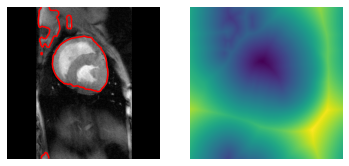

In [5]:
if __name__ == "__main__":
    img = plt.imread('84.pgm')
    mask = np.zeros(img.shape)
    mask[20:100, 20:100] = 1

    chanvese(img, mask, max_its=400, alpha=0.2, display=True, stepsize=20)

iteration: 0
iteration: 100
iteration: 200
iteration: 300
iteration: 400
iteration: 500
iteration: 600
iteration: 700
iteration: 800
iteration: 900
iteration: 1000
iteration: 1100
iteration: 1200
iteration: 1300
iteration: 1400
iteration: 1500
iteration: 1600
iteration: 1700
iteration: 1800
iteration: 1900
iteration: 2000


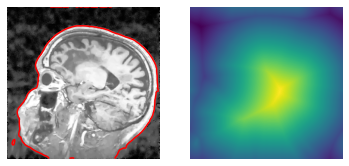

In [6]:
if __name__ == "__main__":
    img = plt.imread('brain.pgm')
    mask = np.zeros(img.shape)
    mask[20:100, 20:100] = 1

    chanvese(img, mask, max_its=2000, alpha=0.2, display=True, stepsize=100)